In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Se carga el dataset para entrenar el modelo
df = pd.read_parquet('data_to_train_model.parquet')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133503 entries, 0 to 1133502
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   LocationID            1133503 non-null  int64  
 1   Year                  1133503 non-null  int32  
 2   Month                 1133503 non-null  int32  
 3   Day                   1133503 non-null  int32  
 4   Hour                  1133503 non-null  int32  
 5   Day_of_week           1133503 non-null  int32  
 6   trips                 1133503 non-null  int64  
 7   Borough               1133503 non-null  object 
 8   temperature_2m        1133503 non-null  float32
 9   relative_humidity_2m  1133503 non-null  float32
 10  dew_point_2m          1133503 non-null  float32
 11  apparent_temperature  1133503 non-null  float32
 12  weather_code          1133503 non-null  float32
 13  pressure_msl          1133503 non-null  float32
 14  cloud_cover           1133503 non-

## Random Forest Regressor

Cross-Validation MSE: 1507.1745463167879 ± 11.366263903073119
Mean Squared Error (MSE): 1471.2958631712368
Mean Absolute Error (MAE): 19.684715805347107
R² Score: 0.6233339575981081
Importancia de las Características:
LocationID              0.634130
Hour                    0.076838
relative_humidity_2m    0.035867
wind_speed_10m          0.030673
wind_direction_10m      0.030335
temperature_2m          0.029025
dew_point_2m            0.028795
apparent_temperature    0.027704
wind_gusts_10m          0.026469
pressure_msl            0.022445
Day_of_week             0.015612
cloud_cover             0.013628
Day                     0.012125
Month                   0.008454
weather_code            0.007900
dtype: float64


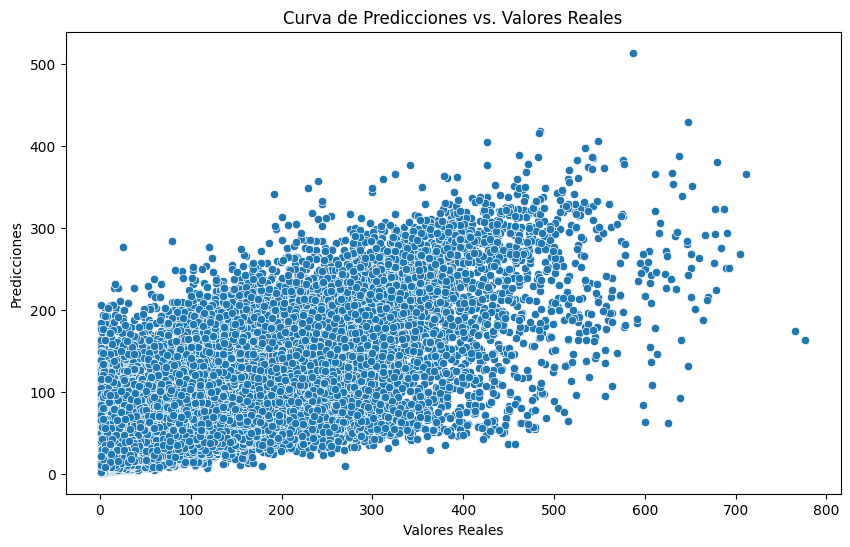

In [4]:
# Variables predictoras (X) y variable objetivo (y)
predictors = [
    'LocationID', 'Day', 'Month', 'Hour', 'Day_of_week',
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
    'apparent_temperature', 'weather_code',
    'pressure_msl', 'cloud_cover', 'wind_speed_10m',
    'wind_direction_10m', 'wind_gusts_10m'
]
X = df[predictors]
y = df['trips']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo Random Forest con ajustes en los hiperparámetros
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Validación cruzada para evaluar el modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()} ± {scores.std()}")

# Predecir con los datos de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

importancia_caracteristicas = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print("Importancia de las Características:")
print(importancia_caracteristicas)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Curva de Predicciones vs. Valores Reales")
plt.show()


## XGBoost

Cross-Validation MSE: 277.17002671572834 ± 75.04862570422495
Mean Squared Error (MSE): 171.70621898759947
Mean Absolute Error (MAE): 5.602492181628163
R² Score: 0.9560415744781494
Importancia de las Características:
LocationID              0.504365
Hour                    0.183845
Day_of_week             0.084428
wind_gusts_10m          0.031362
apparent_temperature    0.026836
relative_humidity_2m    0.021290
Month                   0.021232
wind_speed_10m          0.019687
wind_direction_10m      0.018756
weather_code            0.018416
dew_point_2m            0.016294
cloud_cover             0.016047
pressure_msl            0.015429
temperature_2m          0.013933
Day                     0.008079
dtype: float32


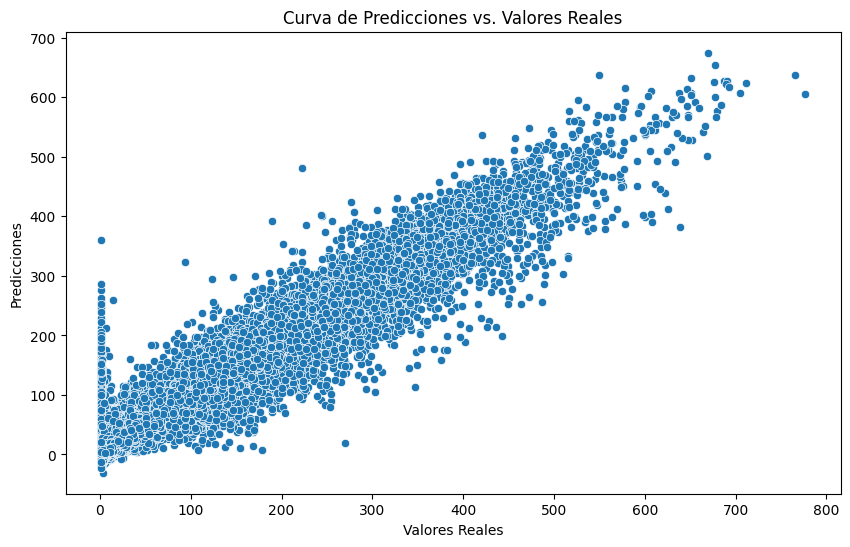

In [3]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Variables predictoras (X) y variable objetivo (y)
predictors = [
    'LocationID', 'Day', 'Month', 'Hour', 'Day_of_week',
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 
    'apparent_temperature', 'weather_code',
    'pressure_msl', 'cloud_cover', 'wind_speed_10m',
    'wind_direction_10m', 'wind_gusts_10m'
]
X = df[predictors]
y = df['trips']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Validación cruzada para evaluar el modelo
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-scores.mean()} ± {scores.std()}")

# Predecir con los datos de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Importancia de las características
importancia_caracteristicas = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print("Importancia de las Características:")
print(importancia_caracteristicas)

# Visualización de la curva de predicciones vs. valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Curva de Predicciones vs. Valores Reales")
plt.show()


In [4]:
import joblib

# Guardar el modelo entrenado
joblib.dump(model, 'XGbost_model.pkl')


['XGbost_model.pkl']